In [1]:
!pip install tensorflow scikit-learn matplotlib seaborn pillow

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision

import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
mixed_precision.set_global_policy('mixed_float16')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset located at: /content/drive/MyDrive/AneDasaset
Contents of /content/drive/MyDrive/AneDasaset:
['Anemic_individuals', 'Healthy_individuals']


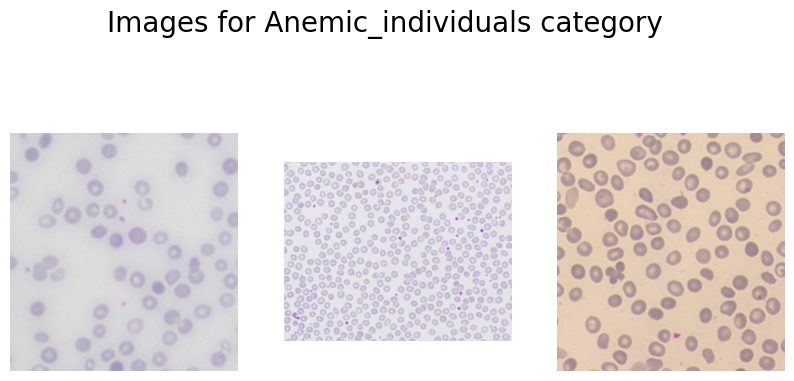

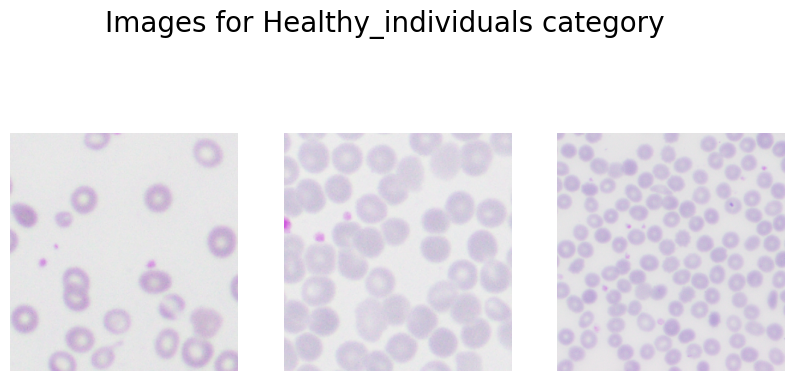

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# -----------------------------------------------------------
# Define Dataset Path
# -----------------------------------------------------------
data_base_path = '/content/drive/MyDrive/AneDasaset'

# The dataset is already a directory, no extraction needed.
print(f'Dataset located at: {data_base_path}')

# --- Debugging: List contents of the base path ---
print(f'Contents of {data_base_path}:')
try:
    top_level_contents = os.listdir(data_base_path)
    print(top_level_contents)
except FileNotFoundError:
    print(f'Error: Base path {data_base_path} not found.')
# --------------------------------------------------

# Adjusting path and classes based on actual directory contents
path = data_base_path # The main dataset directory
classes = ['Anemic_individuals', 'Healthy_individuals'] # These are the actual category folders

for cat in classes:
    image_dir = os.path.join(path, cat)

    # --- Debugging: Check if image_dir exists before listing ---
    if not os.path.exists(image_dir):
        print(f'Error: Directory {image_dir} not found. Please check dataset structure.')
        continue
    # ------------------------------------------------------------

    images = os.listdir(image_dir)

    # Only proceed to plot if there are images
    if images:
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))
        fig.suptitle(f'Images for {cat} category', fontsize=20)

        for i in range(min(3, len(images))):
            k = np.random.randint(0, len(images))
            img = np.array(Image.open(os.path.join(image_dir, images[k])))
            ax[i].imshow(img)
            ax[i].axis('off')
        plt.show()
    else:
        print(f'No images found in {image_dir}.')

In [9]:
import os

# List everything in the dataset root
dataset_root = path
print("Contents of dataset root:", os.listdir(dataset_root))

# If there's a single folder inside, go one level deeper
for item in os.listdir(dataset_root):
    item_path = os.path.join(dataset_root, item)
    if os.path.isdir(item_path):
        print(f"Contents of {item}:", os.listdir(item_path))

Contents of dataset root: ['Anemic_individuals', 'Healthy_individuals']
Contents of Anemic_individuals: ['0388_08_a.png', '0397_04_a.png', '0397_05_a.png', '0402_03_a.png', '0393_11_a.png', '0397_08_a.png', '0401_01_a.png', '0399_11_a.png', '0394_08_a.png', '0400_09_a.png', '0394_01_a.png', '0400_03_a.png', '0398_01_a.png', '0398_05_a.png', '0401_12_a.png', '0399_01_a.png', '0402_06_a.png', '0395_05_a.png', '0393_04_a.png', '0394_12_a.png', '0394_06_a.png', '0397_10_a.png', '0396_09_a.png', '0395_12_a.png', '0393_05_a.png', '0397_01_a.png', '0399_05_a.png', '0397_03_a.png', '0400_12_a.png', '0393_06_a.png', '0401_11_a.png', '0394_09_a.png', '0398_12_a.png', '0394_05_a.png', '0400_01_a.png', '0392_12_a.png', '0397_06_a.png', '0399_06_a.png', '0400_06_a.png', '0398_06_a.png', '0401_07_a.png', '0397_07_a.png', '0399_03_a.png', '0398_03_a.png', '0394_10_a.png', '0395_03_a.png', '0394_07_a.png', '0396_06_a.png', '0393_12_a.png', '0401_08_a.png', '0400_04_a.png', '0402_01_a.png', '0396_08_a.

In [11]:
# Correct dataset path
dataset_folder = path # `path` already holds '/content/drive/MyDrive/AneDasaset'

# Check what’s inside
print("Contents of dataset root:", os.listdir(dataset_folder))

Contents of dataset root: ['Anemic_individuals', 'Healthy_individuals']


In [12]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
NUM_CLASSES = 2

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_dir = dataset_folder
test_dir = dataset_folder # Assuming the test data is also within the same base folder structure

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 4729 images belonging to 2 classes.
Found 1182 images belonging to 2 classes.


In [18]:
from tensorflow.keras.applications import EfficientNetV2B0

NUM_CLASSES = 2  # binary classification

base_model = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(160,160,3)
)
base_model.trainable = False  # freeze base for transfer learning

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')  # 2 classes
])

In [22]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 5, 5, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,088,658 (23.23 MB)

 Trainable params: 166,786 (651.51 KB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(patience=3, restore_best_weights=True)]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1528s 10s/step - accuracy: 0.5256 - loss: 0.8044 - val_accuracy: 0.4239 - val_loss: 0.6934
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.5412 - loss: 0.7531 - val_accuracy: 0.4230 - val_loss: 0.6943
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.5155 - loss: 0.7478 - val_accuracy: 0.6565 - val_loss: 0.6917
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.5286 - loss: 0.7283 - val_accuracy: 0.6997 - val_loss: 0.6876
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.5457 - loss: 0.7089 - val_accuracy: 0.5990 - val_loss: 0.6888
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.5473 - loss: 0.7102 - val_accuracy: 0.5770 - val_loss: 0.6936
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.5339 - loss: 0.7064 - val_accuracy: 0.5770 - val_loss: 0.6916


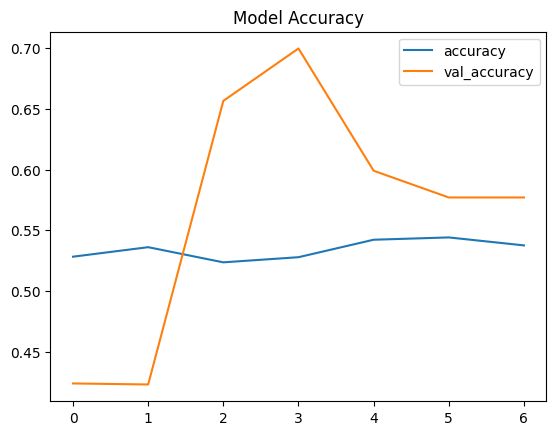

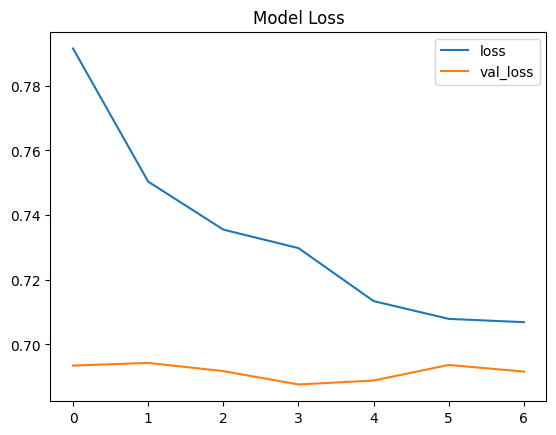

In [25]:
# -----------------------------------------------------------
# Plot Accuracy and Loss
# -----------------------------------------------------------
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Model Accuracy")
plt.show()

history_df.loc[:, ['loss', 'val_loss']].plot(title="Model Loss")
plt.show()


In [26]:
base_model.trainable = True

for layer in base_model.layers[:-40]:
    layer.trainable = False

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.5304 - loss: 0.8395 - val_accuracy: 0.5770 - val_loss: 0.6825
Epoch 2/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.5358 - loss: 0.8154 - val_accuracy: 0.5770 - val_loss: 0.6914
Epoch 3/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.5315 - loss: 0.8093 - val_accuracy: 0.5778 - val_loss: 0.6740
Epoch 4/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.5263 - loss: 0.7837 - val_accuracy: 0.5770 - val_loss: 0.6967
Epoch 5/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.5458 - loss: 0.7518 - val_accuracy: 0.5770 - val_loss: 0.7051


In [29]:
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

Found 5911 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.8913 - loss: 0.5593
Test Accuracy: 0.5775672197341919


185/185 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step


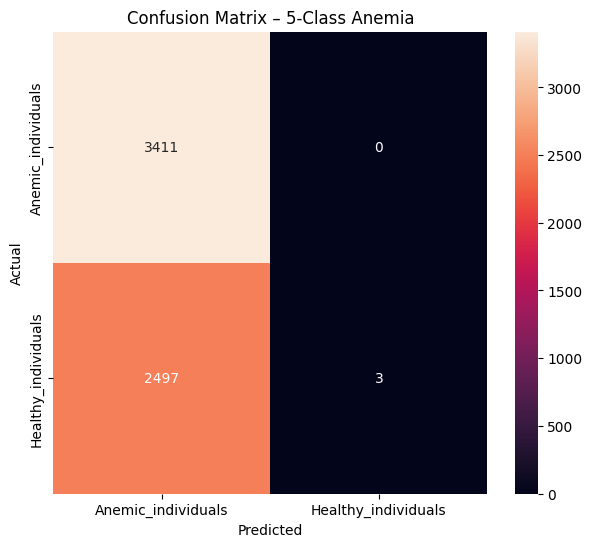

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_prob = model.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes

class_names = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – 5-Class Anemia")
plt.show()

In [33]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

                     precision    recall  f1-score   support

 Anemic_individuals       0.58      1.00      0.73      3411
Healthy_individuals       1.00      0.00      0.00      2500

           accuracy                           0.58      5911
          macro avg       0.79      0.50      0.37      5911
       weighted avg       0.76      0.58      0.42      5911



In [34]:
model.save("anemia_efficientnetv2_5class_model.h5")
print("Model saved successfully!")

Model saved successfully!
